In [1]:
__author__           = "Anzal KS"
__copyright__        = "Copyright 2022-, Anzal KS"
__maintainer__       = "Anzal KS"
__email__            = "anzalks@ncbs.res.in"
from pathlib import Path
import neo.io as nio
import numpy as np
import pandas as pd
from scipy import signal as spy
import matplotlib as mpl
import matplotlib.pyplot as plt
from pprint import pprint
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from matplotlib.font_manager import FontProperties
#import trace_pattern_plot_x_distributed as tpp
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import multiprocessing
import time
import math
import pdb

In [2]:

"""
Font and color defining functions
"""
y_labels = FontProperties()
y_labels.set_family('sans-serif')
y_labels.set_size('large')
#font.set_style('bold')

sub_titles = FontProperties()
sub_titles.set_family('sans-serif')
sub_titles.set_size('x-large')

main_title = FontProperties()
main_title.set_family('sans-serif')
main_title.set_weight('bold')
main_title.set_size('xx-large')
pre_color = "#377eb8" #pre_color purple 
post_color = "#000000" #post_color yellow 
post_late = "#dede00" # post late blue
p1_c = 'black'
p2_c = 'red'
p3_c = 'green'
pat_c = [p1_c,p2_c,p3_c]

In [3]:
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

In [4]:
selected_cells = '/Users/anzalks/Documents/Expt_data/Recordings/CA1_recordings/x_spread_recording_02Hz_30mins/cells_cumulated/cells_with_ltp'

In [5]:
p = Path(selected_cells)

In [6]:
outdir = p/'raw_plots'
outdir.mkdir(exist_ok=True, parents=True)

In [7]:
def list_folder(p):
    f_list = []
    f_list = list(p.glob('*_cell_*'))
    f_list.sort()
    return f_list

def list_files(p):
    f_list = []
    f_list=list(p.glob('**/*abf'))
    f_list.sort()
    return f_list

In [8]:
"""
1D array and get locations with a rapid rise, N defines the rolling window
"""
def find_ttl_start(trace, N):
    data = np.array(trace)
    data -= data.min()
    data /= data.max()
    pulses = []
    for i, x in enumerate(data[::N]):
        if (i + 1) * N >= len(data):
            break
        y = data[(i+1)*N]
        if x < 0.2 and y > 0.75:
            pulses.append(i*N)
    return pulses


"""
data filter function
"""
def filter_data(data, cutoff, filt_type, fs, order=3):
    b, a = spy.butter(order, cutoff, btype = filt_type, analog=False, output='ba', fs=fs)                                                                                     
    return spy.filtfilt(b, a, data) 

"""
Convert channel names to index as an intiger
"""
def channel_name_to_index(reader, channel_name):
    for signal_channel in reader.header['signal_channels']:
        if channel_name == signal_channel[0]:
            return int(signal_channel[1])

"""
function to find the protocol name for any abf file
"""
def protocol_file_name(file_name):
    f = str(file_name)
    reader = nio.AxonIO(f)
    protocol_name = reader._axon_info['sProtocolPath']
    protocol_name = str(protocol_name).split('\\')[-1]
    protocol_name = protocol_name.split('.')[-2]
    return protocol_name
        
"""
Detects the file name with training data (LTP protocol) in it 
"""
def training_finder(f_name):
    protocol_name = protocol_file_name(f_name)
#    print(f'protocol name = {protocol_name}')
    if 'training' in protocol_name:
        f_name= f_name
    elif 'Training' in protocol_name:
        f_name = f_name
#        print(f'training {f_name}')
    else:
#        print('not training')
        f_name = None
#    print(f'out_ training prot = {f_name}')
    return f_name 

"""
Sort the list of suplied files into pre and post trainign files and return the list 
"""
def pre_post_sorted(f_list):
    found_train=False
    for f_name in f_list:
        training_f = training_finder(f_name)
#        print(f'parsed prot train = {training_f}')
        if ((training_f != None) and (found_train==False)):
            training_indx = f_list.index(training_f)
            # training indx for post will have first element as the training protocol trace
            pre = f_list[:training_indx]
            post = f_list[training_indx:]
#            pprint(f'training file - {training_f} , indx = {training_indx} '
#                f'pre file ={pre} '
#                f'post file = {post} '
#                )
            found_train = True
        elif ((training_f != None) and (found_train==True)):
            no_c_train = f_name
        else:
            pre_f_none, post_f_none, no_c_train = None, None, None
    return [pre, post, no_c_train, pre_f_none, post_f_none ]

"""
Tag protocols with training, patterns, rmp measure etc.. assign a title to the file
"""
def protocol_tag(file_name):
    protocol_name = protocol_file_name(file_name)
    if '12_points' in protocol_name:
        #print('point_protocol')
        title = 'Points'
    elif '42_points' in protocol_name:
        #print('point_protocol')
        title = 'Points'
    elif 'Baseline_5_T_1_1_3_3' in protocol_name:
        #print('pattern protocol')
        title = 'Patterns'
    elif 'patternsx' in protocol_name:
        #print('pattern protocol')
        title = 'Patterns'
    elif 'patterns_x' in protocol_name:
        #print('pattern protocol')
        title = 'Patterns'
    elif 'Training' in protocol_name:
        #print('training')
        title = 'Training pattern'
    elif 'training' in protocol_name:
        #print('training')
        title = 'Training pattern'
    elif 'RMP' in protocol_name:
        #print('rmp')
        title='rmp'
    elif 'Input_res' in protocol_name:
        #print ('InputR')
        title ='InputR'
    elif 'threshold' in protocol_name:
        #print('step_current')
        title = 'step_current'
    else:
        #print('non optical protocol')
        title = None
    return title

"""
Pair files pre and post with point, patterns, rmp etc..
"""
def file_pair_pre_pos(pre_list,post_list):
    point = []
    pattern = [] 
    rmp = []
    InputR = []
    step_current = []
    for pre in pre_list:
        tag = protocol_tag(pre)
#        print(f' tag on the file ={tag}')
        if tag=='Points':
            point.append(pre)
        elif tag=='Patterns':
            pattern.append(pre)
        elif tag =='rmp':
            rmp.append(pre)
        elif tag=='InputR':
            InputR.append(pre)
        elif tag =='step_current':
            step_current.append(pre)
        else:
            tag = None
            continue
    for post in post_list:
        tag = protocol_tag(post)
        if tag=='Points':
            point.append(post)
        elif tag=='Patterns':
            pattern.append(post)
        elif tag=='rmp':
            rmp.append(post)
        elif tag=='InputR':
            InputR.append(post)
        elif tag=='step_current':
            step_current.append(post)
        else:
            tag = None
            continue
#    print(f'point files = {point} '
#           f'pattern files = {pattern}'
#          )
    return [point, pattern,rmp, InputR, step_current]

"""
get cell trace data
"""
def cell_trace(file_name):
    f = str(file_name)
    reader = nio.AxonIO(f)
    channels =reader.header['signal_channels']
    chan_count = len(channels)
    file_id = file_name.stem
    block = reader.read_block(signal_group_mode='split-all')
    segments = block.segments
    sample_trace = segments[0].analogsignals[0]
    sampling_rate = sample_trace.sampling_rate.magnitude
    ti = sample_trace.t_start
    tf = sample_trace.t_stop
    cell_trace_all = []
    for s, segment in enumerate(segments):
        cell = channel_name_to_index(reader,'IN0')
        analogsignals = segment.analogsignals[cell]
        unit = str(analogsignals.units).split()[1]
        trace = np.array(analogsignals)
        cell_trace_all.append(trace) 
        t = np.linspace(0,float(tf-ti),len(trace))
    cell_  = (t,cell_trace_all)
#    print(cell_)
    return [cell_, sampling_rate]

In [9]:
"""
single cell functions
"""
"""
pair pre and post, points and patterns for each cell.
"""
def file_pair(cell_path): 
    cell_id = str(cell_path.stem)
    abf_list = list_files(cell_path)
    sorted_f_list = pre_post_sorted(abf_list)
    pre_f_list = sorted_f_list[0]
    post_f_list = sorted_f_list[1][1:]
    training_f = sorted_f_list[1][0]
    no_c_train = sorted_f_list[2]
    paired_list = file_pair_pre_pos(pre_f_list, post_f_list)
    paired_points = paired_list[0]
    paired_patterns = paired_list[1]
    return [paired_points,paired_patterns]

In [10]:
"""
pattern label functions
"""
# plug in iteration umber and it returns a pattern type
def pat_selector(i):
    if i==0:
        pattern='Trained pattern'
    elif i==1:
        pattern='Overlapping pattern'
    elif i==2:
        pattern='Non overlapping pattern'
    else:
        pattern ='_NA'
    return pattern
def point_selector(i):
    if i<=4:
        point='Trained point'
    elif i>4:
        point='Untrained point'
    return point

In [11]:
"""
Summation functions
"""
def summate_points(array_12_points_response):
    #np.array(array_12_points_response)
    #print(f'len of shape of point array {len(np.shape(array_12_points_response))}')
    p1 = np.sum(array_12_points_response[0:5])
    p2 = np.sum(array_12_points_response[2:8])
    p3 = np.sum(array_12_points_response[8:-1])
    p =[p1,p2,p3]
    return p

In [12]:
"""
Analysis functions
"""
"""
Get peak events by taking TTL into account
"""
def peak_event(file_name,channel_name,pre_post_status):
    f = str(file_name)
    reader = nio.AxonIO(f)
    channels = reader.header['signal_channels']
    chan_count = len(channels)
    file_id = file_name.stem
    block  = reader.read_block(signal_group_mode='split-all')
    segments = block.segments
    sample_trace = segments[0].analogsignals[0]
    sampling_rate = sample_trace.sampling_rate.magnitude
    ti = sample_trace.t_start
    tf = sample_trace.t_stop
    cell_trace_all = []
    TTL_sig_all = []
    for s, segment in enumerate(segments):
        cell = channel_name_to_index(reader,channel_name)
        analogsignals = segment.analogsignals[cell]
        unit = str(analogsignals.units).split()[1]
        trace = np.array(analogsignals)
        cell_trace_all.append(trace) 
        t = np.linspace(0,float(tf-ti),len(trace))
#    print (f'IN0 = {cell_trace_all}')
    for s, segment in enumerate(segments):
        ttl = channel_name_to_index(reader,'FrameTTL')
        analogsignals = segment.analogsignals[ttl]
        unit = str(analogsignals.units).split()[1]
        trace = np.array(analogsignals)
        TTL_sig_all.append(trace) 
        t = np.linspace(0,float(tf-ti),len(trace))
    ttl_av = np.average(TTL_sig_all,axis=0 )
    
    ttl_xi= find_ttl_start(ttl_av, 3)
    
    #print (f' TTL len = {len(ttl_xi)}')
    if len(ttl_xi)<10:
        frame_type='pattern'
    else:
        frame_type='point'
    
    ttl_xf = (ttl_xi+0.075*sampling_rate).astype(int) # 75ms ahead of TTL detected
    bl_xf = (ttl_xi-0.005*sampling_rate).astype(int) # 5ms before of TTL detected
    bl_xi = (bl_xf-0.01*sampling_rate).astype(int) # 10ms before of bl_xf
    cell_trace  = np.average(cell_trace_all, axis =0)
    cell_trace_base_line = np.mean(cell_trace[0:int(0.02*sampling_rate)] )
    cell_trace_av = cell_trace - cell_trace_base_line
    cell_trace_b_sub = cell_trace_all-cell_trace_base_line
    event_av_max = []
    events_max = []
    events_min = []
    pat_trace =[]
    frame_dict ={}
    raw_trace_dict ={}
    frame_dict[f'{frame_type}']=dict()
    raw_trace_dict[f'{frame_type}']=dict()
    frame_dict[f'{frame_type}'][f'{pre_post_status}']=dict()
    raw_trace_dict[f'{frame_type}'][f'{pre_post_status}']=dict()
    #frame_dict['pre_post_stat']='pre'
    for i,ti in enumerate(ttl_xi):
        event_av_max.append(np.max(cell_trace_av[ttl_xi[i]:ttl_xf[i]]))
        pattern_max = []
        pattern_min = []
        pt_trace = []
        frame_dict[f'{frame_type}'][f'{pre_post_status}'][f'frame_no_{i}']=dict()
        for n, ni in enumerate(cell_trace_all):
            frame_dict[f'{frame_type}'][f'{pre_post_status}'][f'frame_no_{i}'][f'trial_{n}']=dict()
            r_t =ni[ttl_xi[i]:ttl_xf[i]]
            b_l = np.mean(ni[bl_xi[i]:bl_xf[i]],axis=0)
            bl_t = ni[bl_xi[i]:bl_xf[i]]-b_l
            p_t = r_t-b_l
            pat_t = ni[bl_xi[i]:ttl_xf[i]]
            pt_trace.append(pat_t)
            pt_max = np.max(p_t)
            pt_min = np.min(p_t)
            pattern_max.append(pt_max)
            pattern_min.append(pt_min)
            frame_dict[f'{frame_type}'][f'{pre_post_status}'][f'frame_no_{i}'][f'trial_{n}']['max']=pt_max
            frame_dict[f'{frame_type}'][f'{pre_post_status}'][f'frame_no_{i}'][f'trial_{n}']['min']=pt_min
        events_max.append(pattern_max)
        events_min.append(pattern_min)
        pat_trace.append(pt_trace)
    #print(f'peak_event worked, events ={events}')
    #print('dict values')
    #pprint(frame_dict)
    #df=pd.DataFrame.from_dict(frame_dict,orient='index')
    #print(df)
    return [event_av_max, events_max,pat_trace,sampling_rate, frame_dict]



"""
Raw epsp response amplitude values 
"""

def raw_peak_dist(points_or_pattern_file_set_abf,ch_id='cell'):
    if ch_id=='cell':
        ch_name='IN0'
    elif ch_id=='field':
        ch_name='Field'
    #print(f'ch Id = {ch_name}')
    pre_f = points_or_pattern_file_set_abf[0]
    post_f = points_or_pattern_file_set_abf[1:]
    cell_events_pre = peak_event(pre_f,ch_name,'pre')
    cell_events = []
    for ix,i in enumerate(post_f):
        m = peak_event(i,ch_name,f'post_{ix}')
        cell_events.append(m)
    
    epsp_pre_dict =cell_events_pre[-1]
    epsp_pre_av = cell_events_pre[0]
    epsp_pre = cell_events_pre[1]
    epsp_pre_raw = cell_events_pre[2]
    epsp_post_av = []
    epsp_post = []
    epsp_post_raw = []
    epsp_post_dict=[]
    for p,px in enumerate(post_f):
        epsp_post_raw.append(cell_events[p][2]) #IN0 for cell channel
        epsp_post.append(cell_events[p][1]) #IN0 for cell channel
        epsp_post_av.append(cell_events[p][0]) #IN0 for cell channel
        epsp_post_dict.append(cell_events[p][-1])
    #print(f' len post dict = {len(epsp_post_dict)},len pre {len(epsp_pre_dict)}')
    #for i in epsp_post_dict:
    #    epsp_dict.update(i)
    #pprint(epsp_dict)
    epsp_raw = [epsp_pre_raw,epsp_post_raw]
    epsp_pre = [epsp_pre_av,epsp_pre]
    epsp_post = [epsp_post_av,epsp_post]
    epsp_sampling_rate = cell_events_pre[3]
    epsp_dict = [epsp_pre_dict,epsp_post_dict]
    epsp_events = [epsp_pre,epsp_post,epsp_raw,epsp_sampling_rate,epsp_dict]
    #print(f'raw_peak_dist_worked')
    return epsp_events


"""
Field response amplitudes
"""
def raw_field_dist(points_or_pattern_file_set_abf):
    global epsp_post_raw
    pre_f = points_or_pattern_file_set_abf[0]
    post_f = points_or_pattern_file_set_abf[1:]
    epsp_pre = peak_event(pre_f,'Field')[1] #IN0 for cell channel

    epsp_pre_raw = peak_event(pre_f,'Field')[2] #IN0 for cell channel
    epsp_post = []
    epsp_post_raw = []
    for p in post_f:
        epsp_post_raw.append(peak_event(p,'Field')[2]) #IN0 for cell channel
        epsp_post.append(peak_event(p,'Field')[1]) #IN0 for cell channel
    epsp_raw = [epsp_pre_raw,epsp_post_raw]
    epsp_events = [epsp_pre,epsp_post,epsp_raw]
    #print(f'raw_peak_dist_worked')
    return epsp_events

In [13]:
"""
Unpack nested dictionary: all keys to columns
['frame_type','pre_post','frame_no','trial','epsp_peak','epsp_min']
"""
            
def stack_all_dict(dict_to_add,list_of_cols_for_df):
    rows = list()
    df = pd.json_normalize(dict_to_add)
    for col in df:
        row = col.split(sep='.')
        row.append(df.iloc[0][col])
        rows.append(row)
    data = pd.DataFrame(rows, columns=list_of_cols_for_df)
    return data
    

In [14]:
"""
Data frame generation for all cells
"""
def df_from_cells(cells,outdir):
    
    cell_no = len(cells)
    cols_raw = ['cell_ID','points_raw','patterns_raw']
    cols_extract = ['cell_ID','points_extract','patterns_extract']
    #cols_dict = ['cell_ID','frame_type','pre_post','frame_no','trial','epsp_peak','extracted_val']
    #cols = ['cell_ID','points_extract','patterns_extract','sum_points']
    cell_raw_trace = pd.DataFrame(columns=cols_raw)
    cell_exctracted_data = pd.DataFrame(columns=cols_extract)
    cell_dict = pd.DataFrame()
    for ci, c in enumerate(cells):
        #path for each cell/ folder path to abs with one cell's data.
        cell_path = c
        #folder name with all abfs of a cell
        cell_ID = str(c).split('/')[-1]
        #print(f'analysing cell {ci+1}/{cell_no}, ID: {cell_ID}')
        #pairs optical protocols with pre and post aftr detecting training file, returns both patterns and points
        files_paired = file_pair(c)
        #idexed to get point files and patterns(list of files with pre and post) 0= points, 
        points = files_paired[0]
        patterns = files_paired[1]
        #raw_peak_dist()[i], returns i=>  0=average max value, 1=max for all trials(no. of reps), 
        #2= raw trace (both pre and post in it), 3= sampling rate
        points = raw_peak_dist(points)
        patterns = raw_peak_dist(patterns)
        
        #returns nested dict 
        point_dict =points[-1]
        patterns_dict = patterns[-1]
        #patterns_frame_type=patterns_dict[0]['pattern']
        #points_frame_type=point_dict[0]['point']
        #patterns_dict_all = patterns_dict[0]
        #pdb.set_trace()
        #for i in patterns_dict[1:]:
         #   patterns_dict_all.update(i)
        #print(patterns_dict_all)
    
        # make df from dict
        cols_dict = ['frame_type','pre_post','frame_no','trial','epsp_peak','extracted_val']
        pre_point = stack_all_dict(point_dict[0],cols_dict)
        all_frames = pd.DataFrame()
        for i in point_dict[1]:
            all_frames =all_frames.append(stack_all_dict(i,cols_dict))
        all_frames = pre_point.append(all_frames)
        pre_patterns = stack_all_dict(patterns_dict[0],cols_dict)
        for i in patterns_dict[1]:
            all_frames= all_frames.append(stack_all_dict(i,cols_dict))
        all_frames= all_frames.append(pre_patterns)
        #print(f' df = {all_frames}')
        #print(f'frame type dict list = {patterns_frame_type}')
        epsps_points_pre_max_all_reps = points[0][1]
        epsps_points_post_max_all_reps = points[1][1]
        epsps_patterns_pre_max_all_reps = patterns[0][1]
        epsps_patterns_post_max_all_reps = patterns[1][1]
        
        
        #raw traces all trials.
        points_sampling_rate = points[3]
        patterns_sampling_rate = patterns[3]
        epsps_points_pre_trace_all_reps = points[2][0]
        epsps_points_post_trace_all_reps = points[2][1]
        epsps_patterns_pre_trace_all_reps = patterns[2][0]
        epsps_patterns_post_trace_all_reps = patterns[2][1]
        points_extract = [epsps_points_pre_max_all_reps,epsps_points_post_max_all_reps]
        points_raw = [epsps_points_pre_trace_all_reps,epsps_points_post_trace_all_reps]
        patterns_extract = [epsps_patterns_pre_max_all_reps,epsps_patterns_post_max_all_reps]
        patterns_raw = [epsps_patterns_pre_trace_all_reps,epsps_patterns_post_trace_all_reps]
        
        sum_points_pre = summate_points(epsps_points_pre_max_all_reps)
        #print(f'shape of sum points pre = {np.shape(sum_points_pre)}')
        sum_points_post = summate_points(epsps_points_post_max_all_reps)
        #print(f'shape of sum points post = {np.shape(sum_points_post)}')
        #sum_points = [sum_points_pre,sum_points_post]
        #cell_dict = cell_dict.append{'cell_ID':cell_ID,'pre_post':,'frame_type':,'frame_no':,'trial':,'epsp_peak':,'epsp_min':,'width':},ignore_index=True)
        #cell_raw_trace = cell_raw_trace.append({'cell_ID':cell_ID,'points_raw':points_raw,'patterns_raw':patterns_raw},ignore_index=True)
        #cell_exctracted_data = cell_exctracted_data.append({'cell_ID':cell_ID,'frame_type':point_dict['pattern'],})#'pre_post','frame_no','trial','epsp_peak','epsp_min','width'},ignore_index=True)
        #cell_exctracted_data = cell_exctracted_data.append({'cell_ID':cell_ID,'points_extract':points_extract,'patterns_extract':patterns_extract,'sum_points':sum_points},ignore_index=True)
        cell_exctracted_data = None
        all_frames['cell_ID']=cell_ID 
        cell_dict= cell_dict.append(all_frames,ignore_index=True)
    print(f'{cell_no} analysed')
    return cell_dict

In [15]:
ts =time.time()
cells = list_folder(p)
pd_cells = df_from_cells(cells,outdir)
tf =time.time()
print(f'total time = {tf-ts} (s)')

/var/folders/sc/cpss_44j20qbqjd8khtbyldc0000gn/T/ipykernel_1050/599740019.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_frames =all_frames.append(stack_all_dict(i,cols_dict))
/var/folders/sc/cpss_44j20qbqjd8khtbyldc0000gn/T/ipykernel_1050/599740019.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_frames =all_frames.append(stack_all_dict(i,cols_dict))
/var/folders/sc/cpss_44j20qbqjd8khtbyldc0000gn/T/ipykernel_1050/599740019.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_frames =all_frames.append(stack_all_dict(i,cols_dict))
/var/folders/sc/cpss_44j20qbqjd8khtbyldc0000gn/T/ipykernel_1050/599740019.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

7 analysed
total time = 54.70781493186951 (s)


/var/folders/sc/cpss_44j20qbqjd8khtbyldc0000gn/T/ipykernel_1050/599740019.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_frames =all_frames.append(stack_all_dict(i,cols_dict))
/var/folders/sc/cpss_44j20qbqjd8khtbyldc0000gn/T/ipykernel_1050/599740019.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_frames =all_frames.append(stack_all_dict(i,cols_dict))
/var/folders/sc/cpss_44j20qbqjd8khtbyldc0000gn/T/ipykernel_1050/599740019.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_frames =all_frames.append(stack_all_dict(i,cols_dict))
/var/folders/sc/cpss_44j20qbqjd8khtbyldc0000gn/T/ipykernel_1050/599740019.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

In [16]:
pd_cells

,frame_type,pre_post,frame_no,trial,epsp_peak,extracted_val,cell_ID
0,point,pre,frame_no_0,trial_0,max,0.076508,2022_12_19_cell_2
1,point,pre,frame_no_0,trial_0,min,-0.201202,2022_12_19_cell_2
2,point,pre,frame_no_0,trial_1,max,0.256828,2022_12_19_cell_2
3,point,pre,frame_no_0,trial_1,min,0.003532,2022_12_19_cell_2
4,point,pre,frame_no_0,trial_2,max,0.190247,2022_12_19_cell_2
...,...,...,...,...,...,...,...
3847,pattern,pre,frame_no_2,trial_0,min,-0.785889,2023_01_09_cell_3
3848,pattern,pre,frame_no_2,trial_1,max,3.391380,2023_01_09_cell_3
3849,pattern,pre,frame_no_2,trial_1,min,-0.353127,2023_01_09_cell_3
3850,pattern,pre,frame_no_2,trial_2,max,2.895264,2023_01_09_cell_3


In [17]:
p1_max_pre = pd_cells.loc[(pd_cells['frame_type']=='pattern')&(pd_cells['pre_post']=='pre')&(pd_cells['epsp_peak']=='max')&(pd_cells['frame_no']=='frame_no_0')]

In [18]:
p1_max_post = pd_cells.loc[(pd_cells['frame_type']=='pattern')&(pd_cells['pre_post']=='post_3')&(pd_cells['epsp_peak']=='max')&(pd_cells['frame_no']=='frame_no_0')]

In [19]:
p1_max_pre

,frame_type,pre_post,frame_no,trial,epsp_peak,extracted_val,cell_ID
522,pattern,pre,frame_no_0,trial_0,max,0.392990,2022_12_19_cell_2
524,pattern,pre,frame_no_0,trial_1,max,0.455978,2022_12_19_cell_2
526,pattern,pre,frame_no_0,trial_2,max,0.411072,2022_12_19_cell_2
972,pattern,pre,frame_no_0,trial_0,max,0.125031,2022_12_19_cell_3
974,pattern,pre,frame_no_0,trial_1,max,0.470718,2022_12_19_cell_3
976,pattern,pre,frame_no_0,trial_2,max,-0.272110,2022_12_19_cell_3
1512,pattern,pre,frame_no_0,trial_0,max,1.604904,2022_12_21_cell_1
1514,pattern,pre,frame_no_0,trial_1,max,4.099609,2022_12_21_cell_1
1516,pattern,pre,frame_no_0,trial_2,max,1.025787,2022_12_21_cell_1
2214,pattern,pre,frame_no_0,trial_0,max,0.924454,2022_12_30_cell_1


In [20]:
p1_max_post

,frame_type,pre_post,frame_no,trial,epsp_peak,extracted_val,cell_ID
486,pattern,post_3,frame_no_0,trial_0,max,0.925659,2022_12_19_cell_2
488,pattern,post_3,frame_no_0,trial_1,max,0.534332,2022_12_19_cell_2
490,pattern,post_3,frame_no_0,trial_2,max,1.222275,2022_12_19_cell_2
954,pattern,post_3,frame_no_0,trial_0,max,4.212223,2022_12_19_cell_3
956,pattern,post_3,frame_no_0,trial_1,max,3.126007,2022_12_19_cell_3
958,pattern,post_3,frame_no_0,trial_2,max,0.705078,2022_12_19_cell_3
1476,pattern,post_3,frame_no_0,trial_0,max,2.680679,2022_12_21_cell_1
1478,pattern,post_3,frame_no_0,trial_1,max,3.111786,2022_12_21_cell_1
1480,pattern,post_3,frame_no_0,trial_2,max,4.481628,2022_12_21_cell_1
2160,pattern,post_3,frame_no_0,trial_0,max,0.977631,2022_12_30_cell_1


In [21]:
uniq_cells =p1_max_pre['cell_ID'].unique()
print(uniq_cells)

['2022_12_19_cell_2' '2022_12_19_cell_3' '2022_12_21_cell_1'
 '2022_12_30_cell_1' '2023_01_09_cell_1' '2023_01_09_cell_2'
 '2023_01_09_cell_3']


In [22]:
p1_max_pre['extracted_val']

522     0.392990
524     0.455978
526     0.411072
972     0.125031
974     0.470718
976    -0.272110
1512    1.604904
1514    4.099609
1516    1.025787
2214    0.924454
2216    1.986465
2218    2.559357
2754    3.046631
2756    3.384247
2758    1.719650
3294    0.997574
3296    3.366806
3298    0.891838
3834    1.116699
3836    2.863693
3838    2.443375
Name: extracted_val, dtype: float32

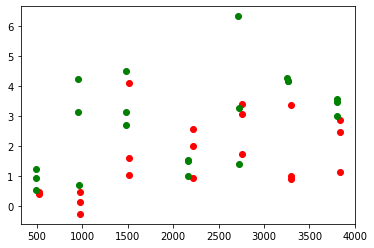

In [23]:
plt.scatter(list(p1_max_pre.index.values), p1_max_pre['extracted_val'], color='r')
plt.scatter(list(p1_max_post.index.values), p1_max_post['extracted_val'], color='g')
plt.show()